# Problem Definition
> Can ML tell my assignments and concept notes apart, especially when they both come from my writing?

Over the last three years, I've been building my personal knowledge database using Obsidian, which primarily consists of markdown files. It's like a digital extension of my brain, consisting course notes and ideas, mostly organized although sometimes incorrect and poorly documented. It has been my go-to for both my class assignments and personal projects. So my assignments were partially born out of my notes, in combination with external sources and ChatGPT.

However, my assignments and my notes, despite coming from the same mind and fingers, serve very different purposes. My assignments are often structured, concise, and aiming to showcase my understanding of a specific topic. On the other hand, my notes are the messy building blocks of knowledge; they're where I explore ideas, make connections, and stored examples.

As I've continued to add more content, I've wondered: could a machine learning model differentiate between my assignments and notes? Did I use different words and phrases in my assignments? A reach goal, but did my writing style also change?

While this is partially a nerdy experiment, I hope that after the model actually exists, it could help automatically tag and organize my assignments based on the content. The text processing work I've done here on my notes may help me in some related tasks, like 
- identifying which notes I used to write my assignments (by comparing similarity between notes and a specific assignment)
- answering some assignment questions based on the content and writing style of my notes


In [2]:
# Requires Python >= 3.10

# Preprocessing
from dataclasses import dataclass, field
from pathlib import Path
from pprint import pprint
from typing import List, Tuple
import fitz # PyMuPDF
import re

# EDA & Viz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# NLP, Training, & Evaluation
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# 2. Data collection and cleaning
## 2.1. Data collection & Ethical considerations

To simplify the process, I focused on the largest subset of my notes, primarily in the fields of Computer Science and Mathematics. This involved creating a duplicate set of 470 markdown files representing my raw notes (note that some notes are empty, waiting to be filled).

Additionally, I obtained 42 assignment PDFs from Minerva Forum. Notably, there are four group assignments labeled with "Group" in their file names, originating from courses like CS110, CS113, and CS111. In these cases, I asked for consent from my involved teammates, ensuring their agreement to use these assignments for training my model.

The following code snippet shows the file count for assignments and notes collected.


In [24]:
DATA_DIR = Path('./data/raw')

# Count the number of .pdf and .md files
assignments_count = sum(1 for _ in DATA_DIR.rglob('*.pdf'))
notes_count = sum(1 for _ in DATA_DIR.rglob('*.md'))

print(f'Assignments: {assignments_count}\nNotes: {notes_count}')

Assignments: 42
Notes: 470


## 2.2. Strip markdown from notes

In the context of text classification, it's often crucial to convert text from various sources into a uniform format, such as plain text, to ensure that the features used for classification are consistent and that the model can effectively learn patterns in the text. Stripping Markdown elements from text is necessary for several reasons:

- **Uniform Representation**: To ensure that the text from different sources, such as markdown files or PDFs, is consistently represented as plain text. This helps in creating a level playing field for the machine learning model, where all text data is in the same format.
- **Noise Reduction & Normalization**: Markdown elements, such as Latex math notations, code blocks, or tags, often represent formatting or structural information that is not needed for text classification. Removing these elements helps in reducing noise and focusing on the actual content that carries relevant information. After that, I can have the normalized plain text, making it easier to compare and analyze.

Here's a summary of how Markdown elements are stripped from text in the provided code:

1. Define a set of regular expressions that match various Markdown elements to be removed, such as front matter, Latex math, code blocks, and others. These patterns are combined into a single pattern, which is used to search and remove multiple Markdown elements simultaneously.
2. Handle alias patterns in Obsidian: A backlink "[[original|alias]]" will be replaced with plain text "alias".
3. Remove empty lines, left after removing code and latex blocks, to clean up the text and make it more concise.
4. With `markdown_to_df` function, process multiple Markdown files, convert them to plain text, and create a DataFrame containing clean text along with source and label information.

In [11]:
@dataclass
class Markdown2Text:
    """Extracts plain text from a directory of Markdown files,
    or a single Markdown file.
    """
    markdown_dir: str = field(default = DATA_DIR)
    markdown_file: str = field(default = None)
    
    def strip_markdown_elements(self, markdown_content:str) -> str|None:
        """Strips Markdown elements from a string of Markdown text.
        
        Args:
            markdown_content (str): String of Markdown text.
        Returns:
            clean_text (str / None): String of text with Markdown elements removed.
        """
        if markdown_content.strip() is None:
            return None
        
        # Define regular expressions for various Markdown elements to remove
        removed_patterns = [
            r'---(.*?)---',          # Front matter
            r'\$\$(.*?)\$\$',        # Latex
            r'```(.*?)```',          # Code blocks
            r'\||---|:---|---:|:--:|:--|:|',  # Table wrappers
            r'\>\s|\[\!(.*?)\]',    # Callout flags
            r'\^.*?\s',              # Block identifiers e.g. ^eg006
            r'\#.*?\s',              # Tags
            r'(\[\[)|(\]\])|(\!\[\[)',     # Backlink wrappers
            r'(\[(.*?)\]\((.*?)\))|(\(\[(.*?)\]\((.*?)\)\))',     # Links
            r'\!\[(.*?)\]\((.*?)\)',       # Images
            r'[\#\*\~\^\=\_\$]|(\s\-)'   # Markdown formatting
        ]
        
        alias_pattern = r'\[\[(.*?)\|([^\]]*)\]\]'
        
        empty_lines = r'/^\s*|\s*$|\s*(\r?\n)\s*|(\s)\s+/g'

        # Combine all patterns into a single pattern
        combined_pattern = '|'.join(removed_patterns)
        
        # Capture backlinks with aliases and replace with purely aliases
        markdown_content = re.sub(alias_pattern, r'\2', markdown_content)
        
        # Remove Markdown elements using the combined pattern, delete the space left behind
        stripped_markdown = re.sub(combined_pattern, '', markdown_content, flags=re.DOTALL)
        
        # Remove empty lines
        clean_text = re.sub(empty_lines, r'\1', stripped_markdown)

        return clean_text

    def markdown_to_text(self, markdown_file:str = None) -> str|None:
        """Turns a markdown file into plain text

        Args:
            markdown_file (str, optional): Defaults to None.
                Markdown file path

        Returns:
            str: Plain text
        """
        if markdown_file is None:
            markdown_file = self.markdown_file
            
        with open(markdown_file, 'r') as file:
            markdown_content = file.read()
        return self.strip_markdown_elements(markdown_content)
    
    def markdown_to_df(self, markdown_dir:str = None, 
                       label:str = 'notes') -> pd.DataFrame:
        """Construct a dataframe of clean text from 
        a directory of markdown files
         
        Args:
            label (str, optional): 
                Label for the dataframe
                
        Returns:
            df (pd.DataFrame): 
                Dataframe with clean text and source
        """
        if markdown_dir is None:
            markdown_dir = self.markdown_dir
            
        path = Path(markdown_dir)
            
        # get all markdown files in the directory and subdirectories
        markdown_files = list(path.rglob('*.md'))
        
        # create a data dictionary: plain_text, source, and label
        data = []
        for file in markdown_files:
            content = self.markdown_to_text(file)
            
            # if the content is not empty, add to data
            if content.strip():
                data.append({
                    'text': content,
                    'source': file.stem,
                    'label': label
                })
        
        # Create the DataFrame from the list of dictionaries
        df = pd.DataFrame(data)

        return df

md2txt = Markdown2Text()
notes_df = md2txt.markdown_to_df()
print(notes_df.shape)
notes_df.head()

(454, 3)


,text,source,label
0,Object-oriented programming (OOP) is a method ...,OOP,notes
1,Sources\nA data structure used for storing a s...,linked list,notes
2,\nA non-linear data structure whose each node ...,binary tree,notes
3,An indexed data structure that stores key-valu...,hash map,notes
4,\nValidity & Soundness A deductive argument is...,deduction,notes


### 2.3. Extract plain text from assignment PDFs

In this section, I performed two cleaning processes:
1. Extracting plain text from PDFs, ignoring LaTeX and code blocks
2. Breaking down long assignments into chunks of paragraphs, to create smaller pieces with similar length as the notes and more training examples for "assignments" label, which **helps reduce class imbalance**. While I tried the best to make sure the information in each chunk is whole, due to limitations when removing unwanted text in step 1, some chunks are cut off.

#### 2.3.1. Extract plain text 
Similar to stripping markdown elements, removing math and code symbols from assignments help make text inputs more relevant, consistent, and ready for text classification. 

To read and extract text from PDF, I use a library called "PyMuPDF" which can process PDF-like documents more efficiently than pure Python libraries such as PyPDF. It can also scrape properties of text and image blocks, such as color, font, size, and position, which are crucial in filtering out LaTeX and code blocks. Specifically, the steps are:
1. Get a dictionary of text spans and their properties, ignoring images and dehypenating LaTex text when searching. At this point, extracted text includes plain text, LaTex notations, and code blocks.
2. By manually investigating properties for some variations of assignment PDFs (generated by Jupyter Notebook Converter, nbconvert, Overleaf, Google Docs, and RMarkdown), I caught the fonts and styling used only for plain text (and not math or code blocks). The biggest limitations here are that 1) I might have missed some styling for plain text and 2) the defined styling cannot be generalized for other types of PDF.
3. Repeat step 1 and step 2 for all PDF files in the data directory. There is an option to turn on and customize chunking, with details listed below.
#### 2.3.2. Chunk long assignments to reduce class imbalance
I notice during the exploratory data analysis (EDA) that the typical assignment document is substantially longer than a note. Assignments, on average, span approximately 9000 words, which is approximately ten times longer than a typical note, which is around 700 words. More importantly, having 450 notes and only 40 assignments signfies heavy class imbalance.

To provide the model with more "assignments" examples for training, I opted to break down each assignment into smaller, more manageable chunks. Each assignment document is chunked into ten parts. 

**Known limitations**: the definition of "paragraphs" is arbitrarily based on a simple separator `\n`. As a result, a paragraph in this context can represent a single sentence, an entire paragraph, or even some phrases that may have been segmented during the text extraction process. This approach leaves a certain level of arbitrariness in defining paragraphs but serves as a pragmatic solution given the absence of well-defined paragraph structures in the plain text.

While this strategy allows for the creation of more balanced training data, I acknowledge its limitations, primarily related to the arbitrary definition of paragraphs. I welcome feedback and suggestions on how to refine the chunking process and better define paragraph boundaries. This will contribute to more precise and meaningful data preparation for text classification while maintaining the focus on approaching class balance.

In [20]:
@dataclass
class PDF2Text:
    """Extracts plain text from a directory of PDF files, ignoring 
    images, latex, and code blocks. This class only deal with PDFs 
    generated by Google Docs, RMarkdown, LaTeX, Jupyter Notebook (some).
    """
    
    pdf_dir: str = field(default = DATA_DIR)
    pdf_file: str = field(default = None)
    fonts_to_catch: Tuple[str] = field(default_factory = lambda: (
        'Helvetica', 'CMR10', 'LMRoman10', 'SFRM1095', 'LiberationSans', 'Times', 'Arial'
    ))  # RMarkdown, LaTeX (3), Chrominium, Google Docs (2)
    
        
    def pdf_to_txt(self, pdf_path:str = None) -> str:
        """Extracts plain text from a PDF file and write to a text file
        Args:
            pdf_path (str, optional): 
                PDF file path
        Returns:
            str: Plain text
        """
        if pdf_path is None:
            pdf_path = self.pdf_file
            
        doc = fitz.open(pdf_path)
        
        plain_text = '\n'.join([
            span['text'] 
            for page in doc
            for block in page.get_text("dict", 
                                       flags = ~fitz.TEXT_PRESERVE_IMAGES & # ignore mimages
                                        fitz.TEXT_PRESERVE_WHITESPACE & # preserve whitespaces
                                        fitz.TEXT_DEHYPHENATE # dehyphenate words
                                       )["blocks"]
            if block["type"] == 0 # 0 = block of text
            for line in block["lines"]
            for span in line["spans"]
            if ( # only extract spans with text of default styling
                span['flags'] == 4 and 
                len(span['text']) > 5 and 
                (span['font'].startswith(self.fonts_to_catch))
            )
        ])
                     
        return plain_text
        
    def pdf_to_df(self, pdf_dir:str = None, label:str = None, 
                  to_chunk:bool = False, num_chunks:int = 10) -> pd.DataFrame:
        """Construct a dataframe of clean text from a directory of PDF files
         
        Args:
            pdf_dir (str, optional): 
                PDF directory path, default: self.pdf_dir
            label (str, optional): 
                Label for the dataframe, default: None
            to_chunk (bool, optional):
                Whether to break the text into chunks, default: False
            num_chunks (int, optional):
                Number of chunks to break the text into, default 10
                Not valid if to_chunk is False
        Returns:
            df (pd.DataFrame, n x 3): 
                Dataframe with clean text and source
        """
        if pdf_dir is None:
            pdf_dir = self.pdf_dir
            
        if to_chunk and num_chunks is None:
            # default to 10 chunks
            num_chunks = 10
        
        # get all PDF files in the directory and subdirectories
        files = list(Path(pdf_dir).rglob('*.pdf'))
        
        data = []
        # create a list of dicts with 3 keys: text, source, and label
        for file in files:
            content = self.pdf_to_txt(file)
            
            if to_chunk:
                content_chunks = self._break_text_into_chunks(content, num_chunks)
                # add content list as multiple rows to data
                for _, chunk in enumerate(content_chunks):
                    data.append({
                        'text': chunk,
                        'source': file.stem,
                        'label': label
                    })
            else:
                if content.strip():
                    data.append({
                        'text': content,
                        'source': file.stem,
                        'label': label
                    })
        
        # Create the DataFrame from the list of dictionaries
        df = pd.DataFrame(data)
        return df
    
    def _break_text_into_chunks(self, text:str, num_chunks:int) -> List[str]:
        """Breaks text into paragraph chunks
        Args:
            text (str): 
                Text to be broken into chunks
            num_chunks (int): 
                Number of chunks to break the text into
        Returns:
            chunks (list of str): 
                List of text chunks
        """
        # split text into paragraphs
        paragraphs = re.split('\n', text)
        
        # get the number of paragraphs per chunk
        num_paragraphs_per_chunk = max(10, len(paragraphs) // num_chunks + 1)
        
        # initialize an empty list to store chunks
        chunks = []
        
        # loop through the paragraphs, adding the specified number of paragraphs to each chunk
        for i in range(0, len(paragraphs), num_paragraphs_per_chunk):
            chunks.append(' '.join(paragraphs[i:i+ num_paragraphs_per_chunk]))
    
        return chunks
    
pdf2text = PDF2Text()
assignments_df = pdf2text.pdf_to_df(label="assignments")

Since I manually examined properties for some variations of assignment PDFs (generated by Jupyter Notebook Converter, Overleaf[LaTex], Google Docs, and RMarkdown), I might have missed some styling for plain text. Because of that, I list below assignments that are not included in the training data.

In [23]:
# find assignments that are in data/raw, but not captured in assignments_df
set([file.stem for file in Path(DATA_DIR).rglob('*.pdf')]) - set(assignments_df.source)

{'CS50 Variables LBA'}

Assignments
Mean: 8582.21, Median: 6438.00

Notes
Mean: 668.12, Median: 382.50


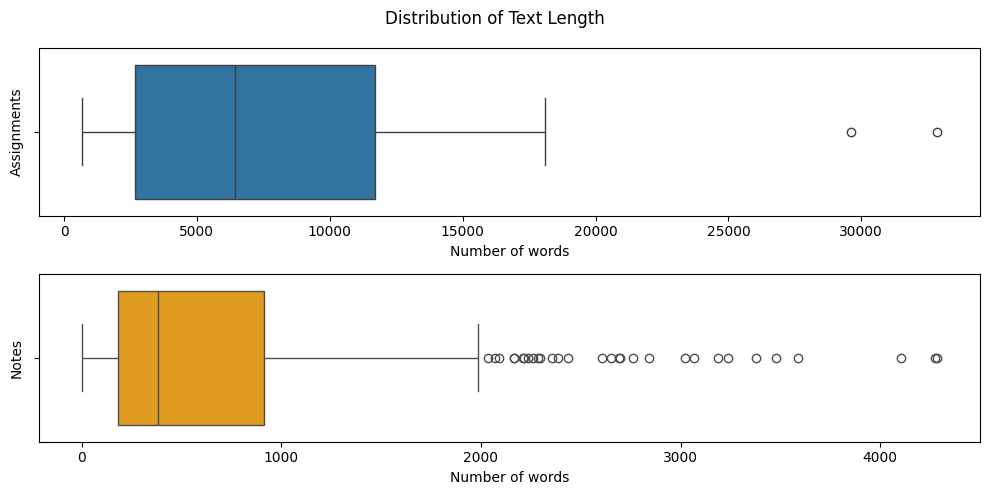

In [13]:
assignments_len = assignments_df.text.apply(len)
notes_len = notes_df.text.apply(len)

# plot horizontal boxplot of text length for both datasets
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
sns.boxplot(x=assignments_len, ax=ax1)
sns.boxplot(x=notes_len, ax=ax2, color='orange')

# print mean and median text length for assignments_df and notes_df
print('Assignments')
print(f'Mean: {assignments_len.mean():.2f}, Median: {assignments_len.median():.2f}')
print('\nNotes')
print(f'Mean: {notes_len.mean():.2f}, Median: {notes_len.median():.2f}')

ax1.set_ylabel('Assignments')
ax2.set_ylabel('Notes')
ax1.set_xlabel('Number of words')
ax2.set_xlabel('Number of words')

plt.suptitle('Distribution of Text Length')
plt.tight_layout()
plt.show()

In [25]:
# Combine original assignments and assignment chunks

assignment_chunks_df = pdf2text.pdf_to_df(label="assignments", to_chunk=True)
assignment_chunks_df = pd.concat([assignments_df, assignment_chunks_df])
print(assignment_chunks_df.shape)
assignment_chunks_df.sample(5, random_state=42)

(425, 3)


,text,source,label
376,thus information wouldn’t spread fast but the ...,CS113 Deep Dive Group LBA,assignments
34,susceptible individuals in the population at g...,CS51 Assignment 2,assignments
135,should have a unique solution. Let 3) for ex...,CS113 Deep Dive 1,assignments
30,Find a matrix A of T with respect to the “stan...,CS113 SBW11,assignments
316,reject the null hypothesis when the evidence f...,CS50 Statistical Inference Report,assignments


In [26]:
df = pd.concat([notes_df, assignment_chunks_df], ignore_index=True)
df['label'] = np.where(df['label'] == 'assignments', 1, 0) 
df['label'] = df['label'].astype('category')
print(df.shape)
df.sample(5, random_state=42)

(879, 3)


,text,source,label
331,\nWhen a sure loss is compared to a larger los...,bad choice,0
247,the probability of observing a sample as extre...,p-value,0
790,Because are the coordinates of the window's ...,CS114 Problem Set 4,1
316,\nclockwise\ncounterclockwise,rotational matrix,0
215,Analysis of Linear Regression model\nQuestions...,regression analysis,0


# 3. Text Preprocessing

## 3.1. SpaCy Removal & Lemmatization
Although I extracted plain text from assignments and notes above, they are still raw. To make them more standardized and amenable to machine learning algorithms, the following additional text processing steps are needed:
1. Remove stopwords, punctuation, and non-alphanumeric characters - which means removing unnecessary elements that don't carry significant meaning for the analysis. By eliminating these elements, the text becomes cleaner, and the focus is placed on more relevant terms.
2. Lemmatizs the tokens, which means converting words to their base or dictionary form. For example, "are" and "is" are reduced to the base form "be." By performing lemmatization, we maintain the core meaning of words while reducing the number of unique words, thereby reducing the dimensionality of the data. This dimensionality reduction can optimize the efficiency and effectiveness of subsequent analysis and machine learning tasks.

Here, I choose SpaCy, which provides pre-trained models for English, which includes stopword lists and lemmatization capabilities, simplifying the text processing workflow. I favor SpaCy over NLTK here due to its efficiency and performance advantages. SpaCy is designed with a focus on production use, making it faster and more memory-efficient than NLTK, which is more oriented towards research and teaching. 

The processed text data will later be used in combination with the TF-IDF (Term Frequency-Inverse Document Frequency) technique. 

In [27]:
def process_text(text:str) -> str:
  """Preprocess text data by removing stopwords, punctuation, and non-alphanumeric characters.

  Args:
      text (str): String of text to preprocess.
      
  Returns:
      str: Preprocessed string of text.
  """
  nlp = spacy.load('en_core_web_sm')
  
  # Create Doc object
  doc = nlp(text)
  
  # Remove stopwords, punctuation, and non-alphanumeric characters
  # And lemmatize tokens
  lemmas = [token.lemma_ for token in doc 
              if not (token.is_stop or token.is_punct) 
              and token.text.isalnum()]
  
  return ' '.join(lemmas)

df['processed'] = df['text'].apply(process_text)
df.head()

,text,source,label,processed
0,Object-oriented programming (OOP) is a method ...,OOP,0,object orient programming OOP method structure...
1,Sources\nA data structure used for storing a s...,linked list,0,source data structure store sequence element a...
2,\nA non-linear data structure whose each node ...,binary tree,0,non linear data structure node 2 child node Co...
3,An indexed data structure that stores key-valu...,hash map,0,indexed data structure store key value pair ke...
4,\nValidity & Soundness A deductive argument is...,deduction,0,Validity Soundness deductive argument mark con...


In [28]:
# Write to csv to save time pre-processing

csv_path = Path('./data/processed/df.csv')
df.to_csv(csv_path, index=False)

In [29]:
# Access a random sample, get its text and processed text
random_sample = df.sample(random_state=42)
print(f"From: {random_sample['source'].values[0]}")
pprint(random_sample['text'].values[0])

From: bad choice
('\n'
 'When a sure loss is compared to a larger loss that is merely probable, '
 'diminishing sensitivity causes risk-seeking\n'
 'Example\n'
 "If I eat a crepe for an overnight snack, it's already unhealthy so it "
 "doesn't matter if I eat more crepes")


In [30]:
pprint(random_sample['processed'].values[0])

('sure loss compare large loss merely probable diminish sensitivity cause risk '
 'seek example eat crepe overnight snack unhealthy matter eat crepe')


## 3.2. TF-IDF (Term Frequency-Inverse Document Frequency)

After the previous step, I have cleaned text. However, machine learning models learn best from numerical representation, so I want to transform the cleaned text into a numerical format. My main goal is to classify whether a text chunk comes from my assignments or my notes, based on word usage, I choose to apply TF-IDF here. 

TF-IDF calculates for each term (characters, words, or phrases) how often it appears in a document (text example) and how unique or important it is across all documents in the dataset. 

$$w_{i,j}=\text{tf}_{i,j} \log\left(\frac{N}{\text{df}_{i}}\right)$$
- $w_{i,j}$ = tf-idf weight for token $i$ in document $j$
- $\text{tf}_{i,j}$ = number of occurrences of tokens $i$ in document $j$
-  $\text{df}_{i,j}$ = number of documents that contain tokens $i$ 
- $N$ = total number of documents in the dataset

In this formula, $tf_{i,j}$ accounts for the local importance of the term within the specific document, while $\log\left(\frac{N}{\text{df}_{i}}\right)$ captures the global importance of the term across the entire dataset.

For each of 800 examples here, I use TF-IDF Vectorizer to calculate TF-IDF weights for most $k$ informative terms, and place them in a $k\times 1$ vector. 

I favor TF-IDF Vectorizer over Count Vectorizer because:
- **Unique Terms Consideration**: In this context, TF-IDF assigns higher weights to terms that are frequent within a specific assignment of mine, but rare across the mixed dataset. It will be useful in telling my assignments apart from my notes. In contrast, CountVectorizer only considers the raw term frequencies, which may not adequately capture the importance of terms.
- **Normalization**: Looking at the formula, TF-IDF normalizes the values based on the number of documents $N$ containing a term. This helps to prevent bias towards longer documents or those with more terms that exists with CountVectorizer.
- **Dimensionality Reduction**: TF-IDF naturally reduces dimensionality by focusing on the most informative terms. This can improve model training time and effectiveness by removing noisy or redundant features. CountVectorizer doesn't inherently perform dimensionality reduction.

The code and further explanation for TF-IDF is included in Section 5.

# 4. Approach for text classification

- Data: assignments and concept-based notes (textual data)
- Task: develop a model that can automatically distinguish between these two classes of text
- Approach: follow the recommended pipeline mentioned in the class below

![](https://file.notion.so/f/s/9947845b-46a7-4272-a6dd-d984252202e7/Untitled.png?id=7ebbaa1a-2bf5-4370-8319-30c47237d89a&table=block&spaceId=ec51ee2f-ecc7-46eb-8a91-73d62cefaefc&expirationTimestamp=1697400000000&signature=1Dynoyys8Wk55nFZhls-mp_IV_YWSnQbWZ1W0KGZtNA&downloadName=Untitled.png)

By now, I have a dataframe ready for model training. Note that the train and test sets below are still **textual data**. However, as discussed in Section 3, I will transform cleaned text through TF-IDF Vectorizer to create numerical representation well-suited for ML models.

If TF-IDF uses 2000 terms, then we have 703 2000-dimensional vectors as the training data, and 176 2000-dimensional vectors as the testing data.


In [31]:
# Split the text data into training (80%) and test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df['processed'], 
    df['label'], 
    test_size=0.2, 
    random_state=42
    )

# Get dimensions of each set (all vectors)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(703,) (176,) (703,) (176,)


# 5. Model selection

I select Naive Bayes and Support Vector Machine (SVM) as the classification algorithms for this text classification task because of their effectiveness in dealing with textual data.

- **Naive Bayes**: Naive Bayes classifiers are particularly well-suited for text classification tasks due to their simplicity and efficiency. They work on the assumption that features (terms in my case) are conditionally independent given the class label (assignments/notes). While this assumption is often unrealistic, naïve Bayes can still perform surprisingly well in many practical applications, especially when I have limited text data here. Naive Bayes can model the likelihood of words occurring in each class and calculate the posterior probabilities $P(\text{class}|\text{term})$
- **SVM**: SVMs are widely used for text classification because they can handle high-dimensional feature spaces effectively. With SVM, I can find a hyperplane that best separates the TF-IDF vectors of "assignment" class from "note" class, while maximizing the gap (margin) between them. This concept is similar to decision boundary seen in class (when we learned logistic regression).

## 5.1. Multinomial Naive Bayes 

Multinomial Naive Bayes computes the posterior probability of a class $C_{k}$, given the values of features $\mathbf{x}$, and selects the class with the highest posterior probability as the predicted class.

Using Bayes Theorem, the posterior probability is calculated as:

$$P(\text{C}_{k}|\mathbf{x}) = \frac{P(\text{C}_{k}) P(\mathbf{x}|\text{C}_{k})}{\sum\limits_{k}P(C_{k})P(\mathbf{x}|C_{k})}$$

It's challenging to compute the likelihood $P(\mathbf{x}∣C_{k})$ because it would require considering the joint probability of observing all terms in the text. To simplify this, we make a "naive" assumption: the features (terms) are conditionally independent given the class. Then the joint probability equates the product of likelihoods for individual feature:
$$P(\text{C}|x_{1},x_{2}, \cdots, x_{n}) = \frac{P(\text{C}_{k}) \prod_{i=1}^{n} P(x_i|\text{C}_{k})}{\sum\limits_{k}P(C_{k})P(\mathbf{x}|C_{k})}$$

- $P(C∣\mathbf{x})$ is the posterior probability of class C given the features $\mathbf{x}$ (each feature is denoted $x_{i}$)
- $P(x_{i}∣C)$ is the likelihood of observing the a feature $x_{i}$ given class $C$.
- $P(C)$ is the prior probability of class $C$. By default, it is the proportion of training examples belonging to a class $C$, out of all training examples.
- $\sum\limits_{k}P(C_{k})P(\mathbf{x}|C_{k})$ or simply $P(\mathbf{x})$ is the marginal likelihood


In [32]:
# Build a pipeline using tfidf and a Naive Bayes classifier
nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True)),
    ('nb', MultinomialNB())
])

## 5.2. Support Vector Machine
> I didn't learn this before, so here is the documentation to the best of my ability. It skipped the formula for decision function and optimization derivation

SVM finds the best possible decision boundary that separates data into different classes, while maximizing the margin between classes 

To understand SVM, we need to familiarize with the following vocabulary:
- **Support vectors**: data points closest to the hyperplane; visually, they touch the margin.
- **Margin**: distance between the hyperplane and the observations closest to the hyperplane (support vectors). In SVM large margin is considered a good margin ![](https://editor.analyticsvidhya.com/uploads/729834.png)
- **Kernel functions:** When complex data isn't linearly separable in the original feature space, kernel functions can map data into higher-dimensional spaces, so it becomes separable (by a hyperplane or decision surface in the image below). ![](https://editor.analyticsvidhya.com/uploads/1403824.png)
- **Decision function:** a function that maps the input to the output score for how close it is to the hyperplane (close to the boundary means a low-confidence decision). Intuitively, it predicts which class the data point belongs to.
- **Loss function:** a function that measures how well the decision function classifies data points. 

We can define the objective function for SVM as: maximizing the margin while minimizing classification errors. Both goals are included in the loss function below.
### 5.2.1.  Loss function 
As discussed, we want to find the hyperplane (decision function) that maximizes the margin. The equation for the hyperplane can be written as:
$$\mathbf{w} \cdot \mathbf{x} + b = \mathbf{w}^ {\intercal}\mathbf{x} +b =0 $$
- $\mathbf{w}$ is the weight vector of the hyperplane.
- $\mathbf{x}$ is the set of data points
- $b$ is the bias term.

The margin $d$ ([derivation](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/#h-important-terms)) is given by:
$$d = \frac{2}{\|\mathbf{w}\|}$$

To maximize the margin, we need to minimize $\mathbf{w}$. However, this is a constrained optimization problem. We need to find the optimal parameters $\mathbf{w}$ and $b$ that maximize the margin while ensuring correct classification.

We introduce the concept of slack variables $\zeta_{i}$ to deal with points that are inside the margin or misclassified. For correctly classified points, $\zeta_{i}=0$, and for points within the margin but correctly classified, $0<\zeta_{i}<1$. For misclassified points, $\zeta_{i} > 1$

We want to minimize $\|\mathbf{w}\|$ (which maximizes the margin) while penalizing misclassification. We do so by minimizing the loss function, defined as:
$$L(\mathbf{w}, b, \zeta) = \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \zeta_i$$

Where:
- $\frac{1}{2} \|\mathbf{w}\|^2$ = regularization term that encourages a large margin.
- $C$ = parameter that controls the trade-off between maximizing the margin and minimizing classification errors.
- $\sum_{i=1}^n \zeta_i$ = sum of slack variables, penalizing misclassified points.

Once the loss function is optimized, we can compute decision function, as the outcome of the training process.
### 5.2.2. Kernel functions 
To define decision function, we need kernel functions that map data to a transformed feature space where data is more easily separable. Here, I use two common kernel functions: linear and radial basis function (RBF). The following formulations are defined with two data points $\mathbf{x}_{i}, \mathbf{x}_{j}$

The linear kernel applies no transformation to feature space and is suitable when the data is linearly separable. It is like drawing a straight line to separate data:
$$K(\mathbf{x}_{i}, \mathbf{x}_{j})=\mathbf{x}_{i} \cdot \mathbf{x}_{j}$$

The RBF kernel maps data into an infinite-dimensional space and is suitable for non-linearly separable data.
$$K(\mathbf{x}_{i}, \mathbf{x}_{j}) =\exp \left(-\frac{\|\mathbf{x}_{i}-\mathbf{x}_{j}\|^{2}}{2\sigma^{2}} \right)$$
where $\sigma$ is the kernel parameter that controls the width of the kernel.

Looking at the formula, it measures the distance between data points and applies a Gaussian weighting. Points close to each other get a high similarity value.
### 5.2.3. Pseudocode
1. Initialize weights $\mathbf{w}$ and bias $b$ to zeros.
2. Choose a kernel function (linear, radial basis function, polynomial).
3. Transform the data into a higher-dimensional space using the chosen kernel.
4. For each data point:
	1. Calculate the loss function 
	2. Update weights $\mathbf{w}$ and bias $b$ to reduce loss function
5. Keep repeating step 4 until the loss function stops decreasing, or decreases minimally. Then we find the best decision boundary with a maximized margin.
6. Fit SVM to new data to make predictions.

In [33]:
# Build a pipeline using tfidf and support vector machine classifier
svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), # transformer
    ('svc', SVC()) # estimator
])

# 6. Training pipeline
1. Feature Extraction: TF-IDF
2. Model Selection: Naive Bayes and SVM
3. Hyperparameter Tuning & Cross Validation: I also perform hyperparameter tuning to find the best combination of hyperparameters for these two pipelines and cross-validation to assess how well the models generalize to unseen data and helps us avoid overfitting. To do both of these steps, I use Grid Search Cross-Validation (Grid Search CV) to systematically search through a range of hyperparameters for each model. Grid Search CV trains and evaluates the models with different hyperparameter combinations
4. Choose the model with hyperparameters that provides the best performance, as determined by cross-validation.

In [34]:
# Define the pipeline parameters to search
nb_params = {
    'tfidf__max_df': (0.5, 0.75, 0.9),
    'tfidf__max_features': (1000, 2000, 5000),
    'tfidf__min_df': (1, 2, 3),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 5)),
    'nb__alpha': (0.01, 0.1, 1.0)
}

# Instantiate the grid search for cross validation
nb_gs = GridSearchCV(nb_pipe, nb_params, cv=10, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
nb_gs.fit(X_train, y_train)

# Get the best score and parameters
print(f'Best cross-validation accuracy: {nb_gs.best_score_:.4f}')
print('Best hyperparameters:')
pprint(nb_gs.best_params_)

# Get the best model
best_nb_model = nb_gs.best_estimator_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


Best cross-validation accuracy: 0.8904
Best hyperparameters:
{'nb__alpha': 0.01,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1)}



1. **Best cross-validation accuracy: 0.89**
   - This means that the Naive Bayes model, when using the specified hyperparameters, correctly classifies 89% of the data during cross-validation.
   - Cross-validation accuracy can estimate the accuracy for out-of-sample data. It signifies that roughly 89% of text chunks are correctly classified into their label.

2. **Best Parameters:**
   - `nb__alpha`: 0.01
     - This is the best value for the Laplace smoothing parameter (alpha) used in the Naive Bayes model. Laplace smoothing is applied to avoid zero probabilities for unseen words.
   - `tfidf__max_df`: 0.5
     - In TF-IDF, it specifies the maximum document frequency for a term. It means that words appearing in more than 50% of the documents are not considered as features.
   - `tfidf__max_features`: 5000
     - This parameter limits the maximum number of features (terms) to consider in the TF-IDF vectorization. Here, the Naive Bayes model will be fed the top 5000 most important features.
   - `tfidf__min_df`: 1
     - In TF-IDF, this represents the minimum document frequency for a term to be included. Here, terms that appear in at least one document are considered.
   - `tfidf__ngram_range`: (1, 1)
     - This parameter defines the range of n-grams to consider. In this case, the best model looks at unigrams (single words).

In [35]:

# Define the pipeline parameters to search
svc_params = {
    'tfidf__max_df': (0.5, 0.75, 0.9),
    'tfidf__max_features': (1000, 2000, 5000),
    'tfidf__min_df': (1, 2, 3),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 5)),
    'svc__C': (0.1, 1.0, 10.0),
    'svc__kernel': ('linear', 'rbf')
}

# Instantiate the grid search for cross validation
svc_gs = GridSearchCV(svc_pipe, svc_params, cv=10, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
svc_gs.fit(X_train, y_train)

# Get the best score and parameters
print(f'Best score: {svc_gs.best_score_:.4f}')
print('Best parameters:')
pprint(svc_gs.best_params_)
# Get the best model
best_svc_model = svc_gs.best_estimator_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
Best score: 0.8861
Best parameters:
{'svc__C': 10.0,
 'svc__kernel': 'rbf',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1)}


Compared to the Naive Bayes pipeline, the highest cross-validation accuracy and the set of hyperparameters for TF-IDF for SVC pipeline are very similar. Except for `'tfidf__max_features': 2000`, where the best-performing SVC model uses maximum 2000 terms (generating 2000 dimensional vector for each document).

The choice of "C" and the "rbf" kernel suggests that the SVM model is optimized for complex, non-linear classification problems.
- `svc__C`: 10.0
     - As mentioned, the "C" parameter is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification error. In this case, the best value for "C" is 10.0; this is a high value, which may lead to a narrower margin but potentially better accuracy.
- `svc__kernel`: 'rbf'
     - This indicates that the more suitable kernel function is Radial Basis Function. Since the linear kernel performed less well here, I assume the data of my assignments and notes are not linearly separable in the original feature space.

# 7. Model evaluation

Naive Bayes test accuracy: 0.8466
SVC test accuracy: 0.8693
Naive Bayes test F1 score: 0.8429
SVC test F1 score: 0.8693


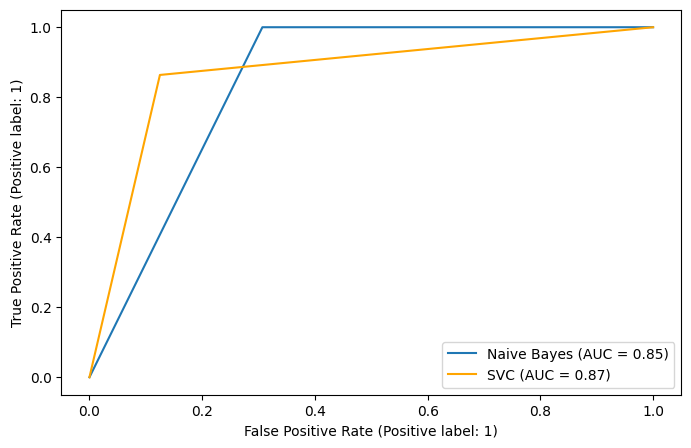

In [37]:
# Predict the labels using the test data
nb_pred = best_nb_model.predict(X_test)
svc_pred = best_svc_model.predict(X_test)

# Get test accuracy and F1 score
nb_acc = accuracy_score(y_test, nb_pred)
nb_f1 = f1_score(y_test, nb_pred, average='weighted')
svc_acc = accuracy_score(y_test, svc_pred)
svc_f1 = f1_score(y_test, svc_pred, average='weighted')

print(f'Naive Bayes test accuracy: {nb_acc:.4f}')
print(f'SVC test accuracy: {svc_acc:.4f}')
print(f'Naive Bayes test F1 score: {nb_f1:.4f}')
print(f'SVC test F1 score: {svc_f1:.4f}')

# display ROC curve
fig, ax = plt.subplots(figsize=(8, 5))
RocCurveDisplay.from_predictions(y_test, nb_pred, name='Naive Bayes', ax=ax)
RocCurveDisplay.from_predictions(y_test, svc_pred, name='SVC', c = 'orange', ax=ax)
plt.show()

- **Test Accuracy**:
   - Naive Bayes: 0.8466
   - SVC: 0.8693
   - Higher accuracy indicates a better-performing model. In this case, the SVC model outperforms Naive Bayes with a higher accuracy score.

- **Test F1 Score**:
   - Naive Bayes: 0.8429
   - SVC: 0.8693
   - The F1 score is a combined metric of precision and recall, and it provides a balance between false positives and false negatives. Like accuracy, a higher F1 score is desirable. In this case, the SVC model again has a higher F1 score, suggesting better performance.

- **AUC (Area Under the ROC Curve)**:
   - Naive Bayes: 0.85
   - SVC: 0.87
   - The AUC represents the model's ability to distinguish between positive and negative instances. A higher AUC indicates a better ability to make these distinctions. The SVC model has a higher AUC, which implies better discrimination between classes.

Based on these metrics, the Support Vector Classifier (SVC) appears to be the better model for the text classification task between assignments and notes. It consistently outperforms Naive Bayes in terms of accuracy, F1 score, and AUC. SVM is well-suited to higher dimension data (I have almost 200 text chunks for testing, each is then transformed to a 2000-dimensional vector through `TfidfVectorizer`).

However, if I have limited data, I might favor Naive Bayes pipeline, which:
- ran faster than SVC with RBF kernel (49.5s < 2m23s)
- is more interpretable (see Section 8) 
- performs well as long as the assumption of conditional independence reasonably holds



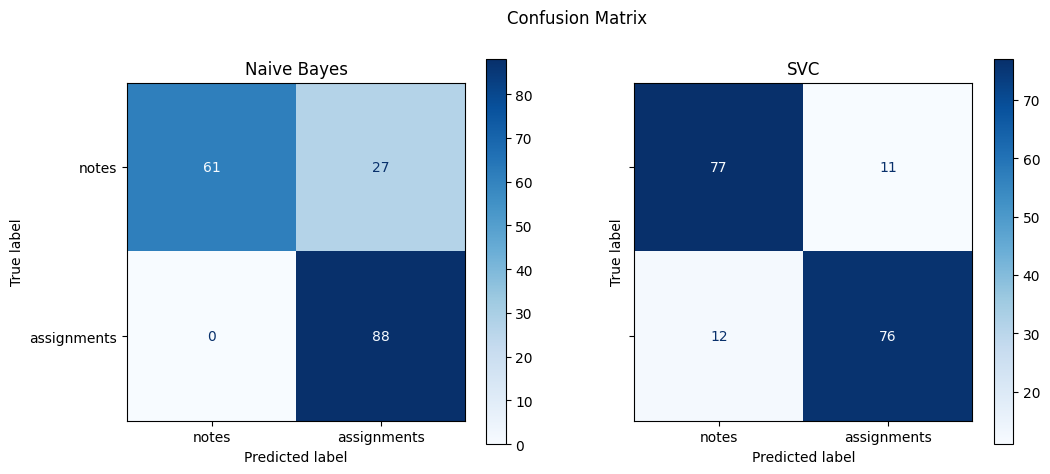

In [38]:
# display confusion matrix side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, nb_pred, 
                                        cmap=plt.cm.Blues, 
                                        display_labels=['notes', 'assignments'], 
                                        ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred, 
                                        cmap=plt.cm.Blues, 
                                        display_labels=['notes', 'assignments'], 
                                        ax=ax2)
ax1.set_title('Naive Bayes')
ax2.set_title('SVC')
plt.show()

To see the breakdown of the two models' performance, I display the Confusion Matrix here:

Naive Bayes
- True Negatives (TN): 61 assignments are correctly identified as assignments
- True Positives (TP): 61 notes are correctly identified as notes
- False Positives (FP): 27 notes are mistakenly classified as assignments
- False Negatives (FN): 0 assignments are missed

Support Vector Machine classifier (SVC):
- True Negatives (TN): 77 assignments are correctly identified
- True Positives (TP): 76 notes are correctly identified 
- False Positives (FP): 11 notes are mistakenly classified as assignments.
- False Negatives (FN): 12 actual assignments are incorrectly predicted as notes

Overall, Naive Bayes is more conservative, making sure not to miss any assignments (FN=0), but it tends to  misclassify some notes as assignments. SVC achieves a better balance between true positives and true negatives but has a slightly higher false negative rate (FN=12)

# 8. Conclusion

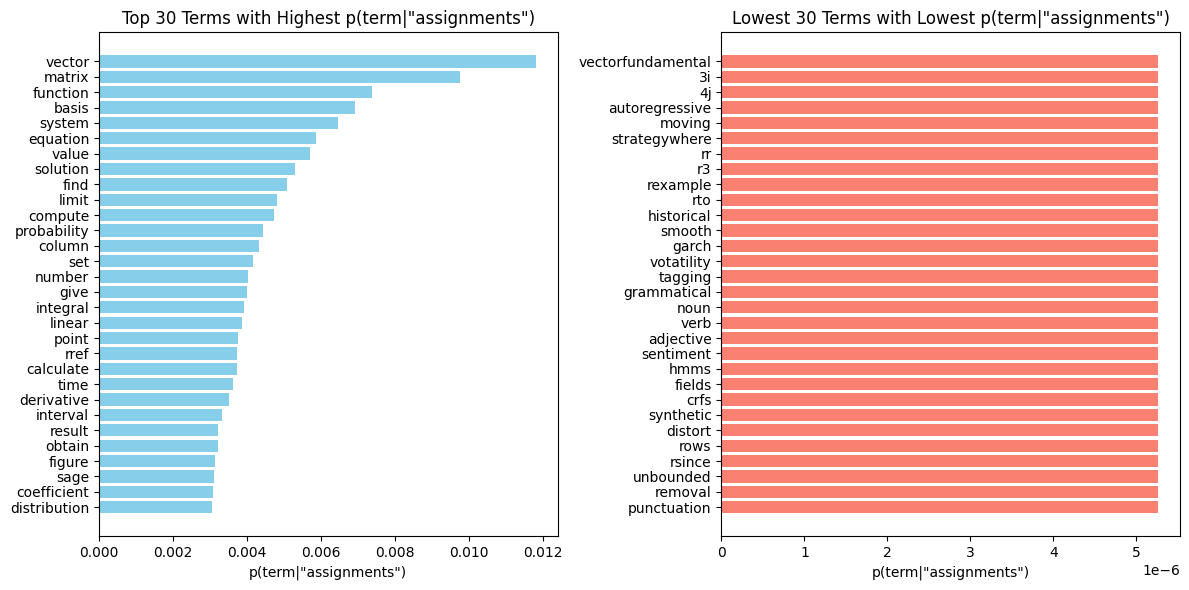

In [39]:
# Reuse my code from PCW session 5
nterms_shown = 30

# Get the log probabilities of features for the 'assignments' class
log_probs = best_nb_model.named_steps['nb'].feature_log_prob_[1]

# Get the vocabulary (mapping of feature indices to tokens)
vocabulary = best_nb_model.named_steps['tfidf'].vocabulary_

# Create a list of (term, p(term|"assignments")) pairs
term_prob_pairs = [(term, np.exp(log_probs[vocabulary[term]])) 
                   for term in vocabulary]

# Sort the pairs by p(X|"assignments") (x[1]) in descending order 
term_prob_pairs.sort(key=lambda x: x[1], reverse=True)

# Extract the top X and lowest X pairs
top_term_probs = term_prob_pairs[:nterms_shown]
bot_term_probs = term_prob_pairs[-nterms_shown:]

# Unpack the pairs into tokens and probabilities for plotting
top_terms, top_probs = zip(*top_term_probs)
bot_terms, bot_probs = zip(*bot_term_probs)

# Create bar plots for the top 30 and lowest 30 tokens
plt.figure(figsize=(12, 6))

# Plot the top 30 tokens
plt.subplot(1, 2, 1)
plt.barh(range(30), top_probs, tick_label=top_terms, color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 30 Terms with Highest p(term|"assignments")')
plt.xlabel('p(term|"assignments")')

# Plot the lowest 30 tokens
plt.subplot(1, 2, 2)
plt.barh(range(30), bot_probs, tick_label=bot_terms, color='salmon')
plt.gca().invert_yaxis()
plt.title('Lowest 30 Terms with Lowest p(term|"assignments")')
plt.xlabel('p(term|"assignments")')

plt.tight_layout()
plt.show()

## Results


Although Naive Bayes performed slightly worse than SVC on test data, it is more interpretable. I plot the terms with highest and lowest posterior probability P(term|assignment) to view which terms were used to make predictions in Naive Bayes.

Top 30 terms are quite reliable. Naive Bayes caught frequent terms used in my core classes:
- CS113: vector, matrix, basis, system, equation, rref, column, linear
- CS111: solution, find, limit, integral, derivative
- CS114: probability, set, distribution
- Other assignment-specific terms: find, solution, give, compute, calculate, result, figure, sage

Bottom 30 terms are a bit messy. However, there are some groups of terms I took while self-styding, therefore never appeared on assignments, for example
- Time series forecasting: autoregressive, historical, GARCH, (and votality since I applied for financial data)
- NLP techniques: sentiment, tagging, grammatical, punctuation, noun, verb, adjective

## Limtations
I acknowledge that through this report, there are known limitations:
- Collected data is biased towards CS113 and CS111 with more assignments (Skill Builders). 2 CS110 assignments was omitted since I couldn't process Forum Workbook.
- Text preprocessing doesn't produce completely cleaned text. There are traces of Latex notations (3i, 4j) as the terms above.
- Chunking long assignments doesn't produce meaningful chunks by themselves. Sometimes the split decision was arbitrary, which might badly impact the performance for both models.
- There might be more powerful models to deal with text classification that I couldn't apply here due to lack of knowledge, such as Long Short-Term Memory (LSTM), Convolutional Neural Network (CNN).

I hope to improve on these limtations in my next assignment.

# Executive Summary

This report entails a text classification task that distinguishes between concept-based notes and assignment documents. For data collection, discussions of ethical considerations and consent, how to extract plain text from raw files, and how to address class imbalance (470 notes and 42 assignments) were provided. The cleaned text was preprocessed through stopwords removal and lemmatization, before being transformed by a TF-IDF vectorizer to create features for two training pipelines, Naive Bayes and Support Vector Machine (SVM). This pipeline encompasses feature extraction using TF-IDF, model training, and hyperparameter tuning and cross-validation using Grid Search CV. 

The results show that SVM performed slightly better on unseen data than Naive Bayes, achieving accuracy score, F1 score and AUC of 87%. Visualizations of terms from Naive Bayes predictions also provide insights into the terms that influence classifications. However, this report acknowledges several limitations, including data bias towards specific course assignments, the presence of uncleaned text traces, class imbalance challenges, and the potential for more advanced models, such as CNN and LSTM.

# AI Statement

I used Copilot as the pair programmer during model training (section 5 & 6), and ChatGPT to summarize the derivation of SVM loss function (before I read other guides).

# References

- Artifex. (n.d.). *Appendix 1: Details on Text Extraction - PyMuPDF 1.23.4 documentation*. https://pymupdf.readthedocs.io/en/latest/app1.html 
- kirgol. (2020, February 28). *How to calculate evidence in Naive Bayes classifier?* Stack Overflow. https://stackoverflow.com/questions/60454210/how-to-calculate-evidence-in-naive-bayes-classifier 
- Nguyen, C. (2023, September 16). *Pre-class Work Session 5. Naive Bayes*. Forum. 
- Saini, A. (2023). Guide on Support Vector Machine (SVM) Algorithm. *Analytics Vidhya*. https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/#h-important-terms